In [535]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import SplineTransformer
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import splev, interp1d
from sklearn.linear_model import LinearRegression

In [536]:
df = pd.read_csv('./Sales_Transactions_Dataset_Weekly.csv')
df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


# Normalize each time series by removing its mean. Store the de-meaned data in an 811-by-52 matrix X.


In [537]:
# Normalize each time series by removing its mean. Store the de-meaned data in an 811-by-52 matrix X.
df_norm = df.copy()[df.columns[1:53]]
df_norm = df_norm.sub(df_norm.mean(axis=1), axis=0)

In [538]:
# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oright, :] = xr @ tt

        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis


#### Fit each time series with an NCS with df = 10. This corresponds to an NCS with 8 interior knots.
Each row of X_811×52 represents the response, with the 1-dimensional feature being the index from
1 to 52.


In [539]:
# Fit each time series with an NCS with df = 10. This corresponds to an NCS with 8 interior knots.
X = df_norm.values
X.shape

(811, 52)

• Store the NCS coefficients (excluding the intercept) in an 811-by-9 matrix $B_{811×9}$.
• Matrix B can be derived as:
	– F is a 52-by-9 design matrix without the intercept. For instance, this can be obtained using
		the ns command in R. Remove the column mean from F to disregard the intercept.
	– The matrix equation is:   $B^t = (F^tF)^{−1}F^tX^t$.
	– The formula above is given for the transpose of B, since it is equivalent to fitting 811 linear
		regression models: the design matrix stays the same (i.e., F) but the response vector —
		there are 811 response vectors corresponding to the 811 rows of X — would vary; each nine
		dimensional regression coefficient vector corresponds to a row in B (or equivalently, column in $B^t$).


In [540]:
# F is a 52-by-9 design matrix without the intercept. For instance, this can be obtained using the ns function.
# Remove the column mean from F to disregard the intercept.
F = ns(np.arange(1, 53), df=9, include_intercept=False)
F -= F.mean(axis=0)
F.shape

(52, 9)

In [541]:
# Calculate Coefficients B
FtF_inv = np.linalg.inv(F.T @ F)
FtF_inv_Ft = FtF_inv @ F.T
Bt = FtF_inv_Ft @ X.T
Bt.shape

(9, 811)

In [542]:
B = Bt.T

In [543]:
B.shape

(811, 9)

Clustering using Matrix B
• Run the k-means algorithm on matrix B to cluster the 811 products into 6 clusters.
• Visualize the centered time series (colored in grey) of products grouped by their clusters. Overlay
the plots with the cluster centers (colored in red). Arrange the visualizations in a 2-by-3 format.
• Note: When using matrix B for clustering, the centers are the average of the rows of B within each
cluster. To get the corresponding time series from a cluster center b, use the matrix product Fb

In [544]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0, max_iter=300).fit(B)
center = kmeans.cluster_centers_

D:\UIUC\CSE_598_Statistical_Learning\MP\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


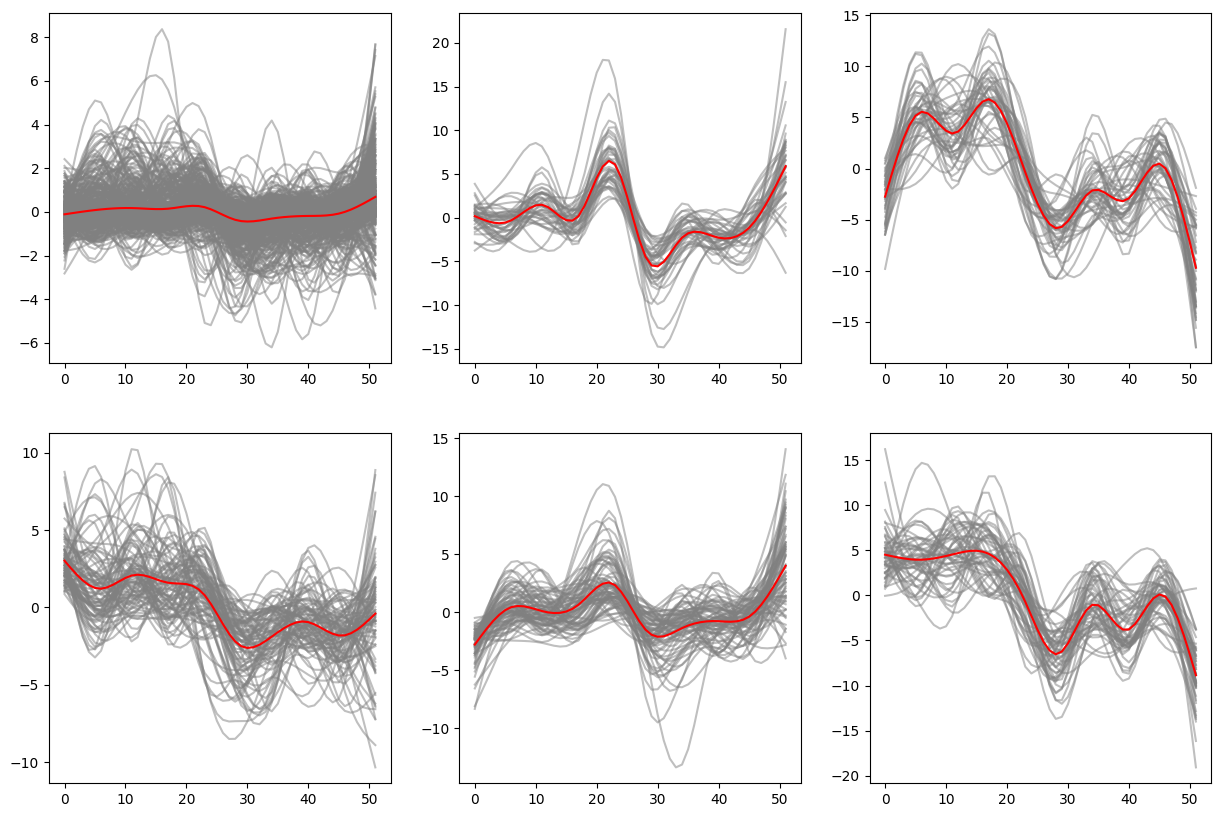

In [545]:
# Visualize the centered time series (colored in grey) of products grouped by their clusters. Overlay
# the plots with the cluster centers (colored in red). Arrange the visualizations in a 2-by-3 format.
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    idx = np.where(kmeans.labels_ == i)[0]
    for j in range(len(idx)):
        axs[i // 3, i % 3].plot(F @ B[idx[j], :], color='grey', alpha=0.5)
    axs[i // 3, i % 3].plot(F @ center[i, :], color='red')


. Clustering using Matrix X
• Run the k-means algorithm on matrix X to cluster the 811 products into 6 clusters.
• Similarly, visualize the centered time series of products grouped by their clusters, accompanied
by their respective cluster centers. Arrange the visualizations in a 2-by-3 format.


D:\UIUC\CSE_598_Statistical_Learning\MP\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


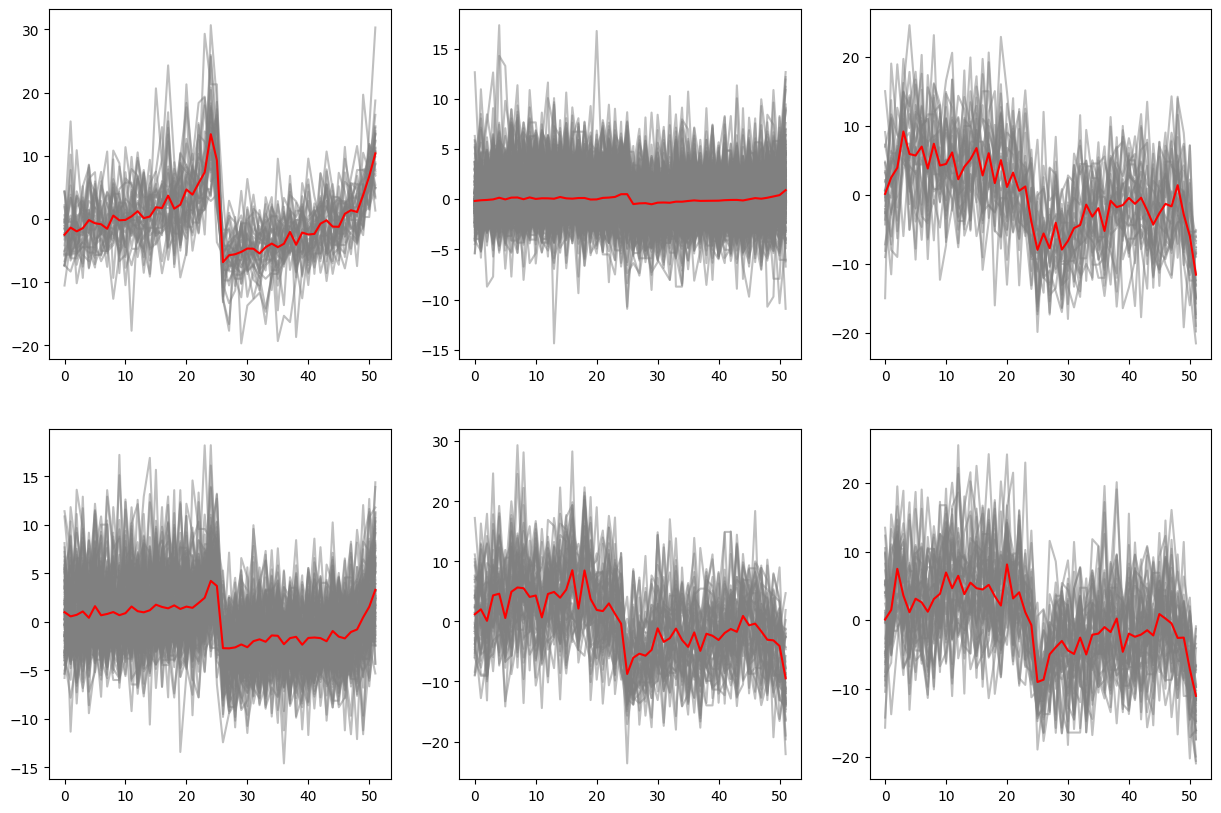

In [546]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
center = kmeans.cluster_centers_
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    idx = np.where(kmeans.labels_ == i)[0]
    for j in range(len(idx)):
        axs[i // 3, i % 3].plot(X[idx[j], :], color='grey', alpha=0.5)
    axs[i // 3, i % 3].plot(center[i, :], color='red')

In [547]:
from scipy.interpolate import BSpline

np.random.seed(0)
X = np.random.rand(811, 52)

# Step 2: Generate Design Matrix F (B-Spline basis)
# Using cubic spline (degree=3) and 8 interior knots, thus df = 10
knots = np.linspace(0, 52, 8)
degree = 3
n_knots = len(knots)
n_basis = 9  # Given in the task description
F = np.zeros((52, n_basis))

# Use BSpline to create the basis functions
for i in range(n_basis):
    b = BSpline(knots, (np.arange(n_basis) == i).astype(float), degree)
    F[:, i] = b(np.linspace(0, 52, 52))

# Center the Design Matrix
F -= F.mean(axis=0)
# Calculate Coefficients B
FtF_inv = np.linalg.pinv(F.T @ F)
FtXt = F.T @ X.T
Bt = FtF_inv @ FtXt
B = Bt.T
B.shape

(811, 9)